※참고  
- https://github.com/lulindev/yolov3-pytorch/blob/master/model/yolov3.py
- https://github.com/developer0hye/PyTorch-Darknet53/blob/master/model.py
- https://github.com/ujsyehao/yolov3-multigpu/blob/master/utils/utils.py
- https://ropiens.tistory.com/43
- https://www.programmersought.com/article/37324711941/

## YOLOv3구현
### YOLOv3 구조  
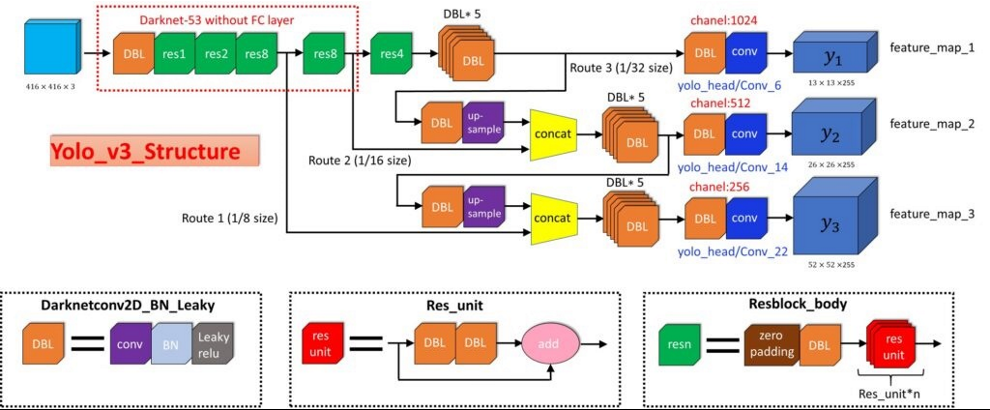  
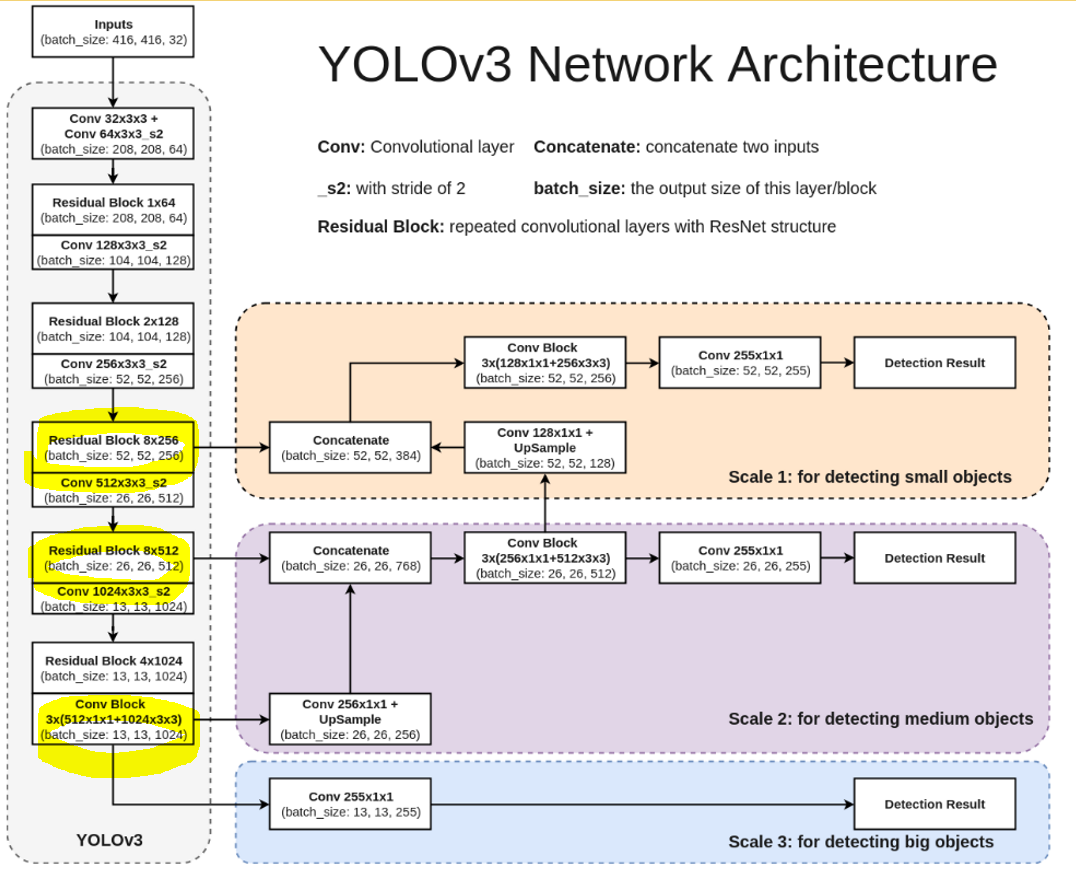
- 아래 그림에서 마지막 피쳐맵을 추출하는 부분은 잘못된것으로 보인다. 이에 대해서는 위의 그림을 참고했다.

### Detection
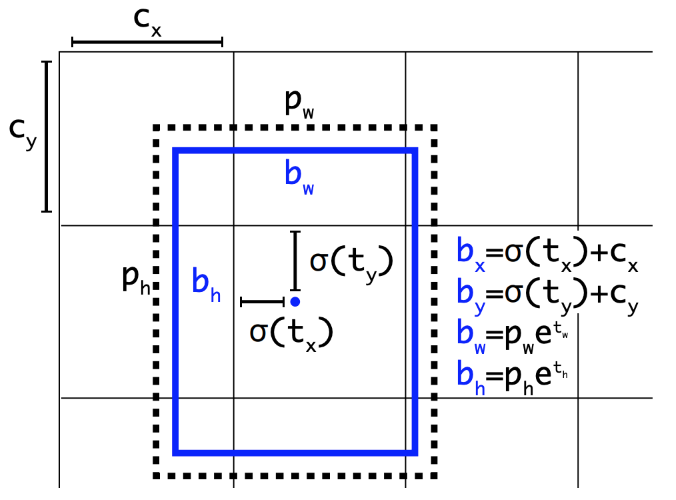  
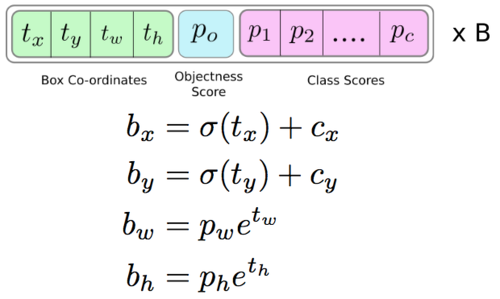  
- cx cy: grid 셀의 좌상단의 좌표(offset)
- pw ph : 우선순위 앵커박스(prior)의 너비 및 높이
- tx ty tw th: 예측한 바운딩 박스의 중심 및 크기
- b_x, b_y, b_w, b_h : 위의 값들을 조정해 실제 GT(Ground Truth, 라벨 값)와 IOU를 계산할 최종 bounding box의 offsets 값
    - 시그모이드를 씌우는 이유: tx, ty의 범윅 0~1 즉 한 cell의 영역으로 제한하기 위함이다. 이를 통해 초기 학습 시 시간낭비를 줄일 수 있다.
### Loss
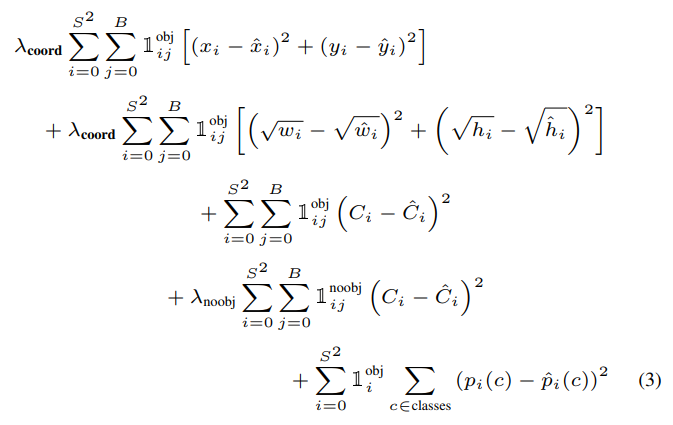
- bbox에 대해서는 MSE(mean squared error), objectness 와 class에 대해서는 BCE(binary cross-entropy)를 사용했다.

### YOLOv3 output  
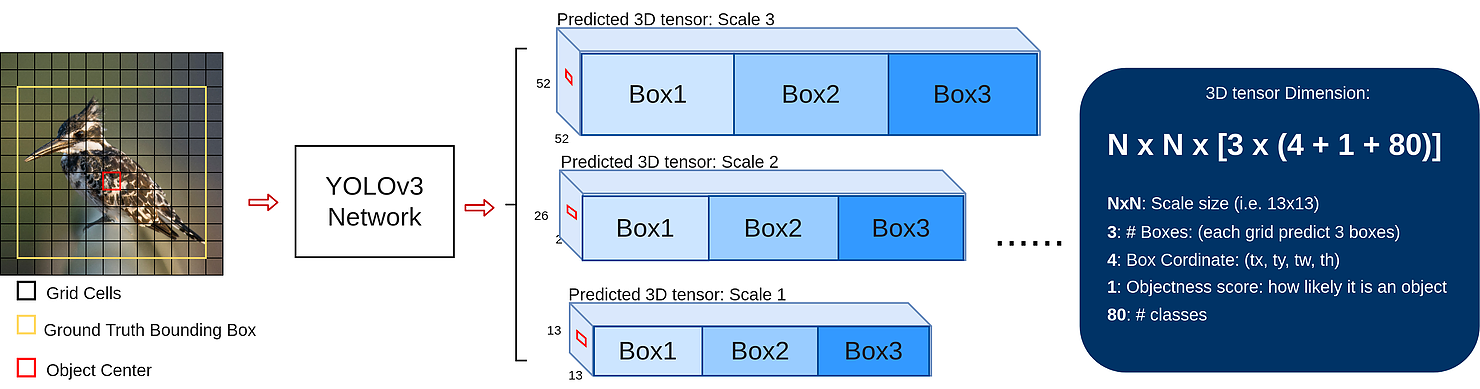

In [4]:
import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F

In [3]:
def Conv(in_channels, out_channels, kernel_size=3, padding=1, stride=1):
    return nn.Sequential(
        nn.Conv2d(in_channels, out_channels, kernel_size=kernel_size, stride=stride, padding=padding, bias=False),
        nn.BatchNorm2d(out_channels),
        nn.LeakyReLU())

# 앵커 박스와 GT 박스 사이의 IOU 계산
def bbox_wh_iou(wh1, wh2):
    wh2 = wh2.t()
    w1, h1 = wh1[0], wh1[1]
    w2, h2 = wh2[0], wh2[1]
    inter_area = torch.min(w1, w2) * torch.min(h1, h2)
    union_area = (w1 * h1 + 1e-16) + w2 * h2 - inter_area
    return inter_area / union_area

def build_targets(pred_boxes, pred_cls, target, anchors, ignore_thres, device):
    # pred_boxes => (batch_size, anchor_num, gride, gride, 4)
    # pred_cls   => (batch_size, anchor_num, gride, gride, 80)
    nB = pred_boxes.size(0)   # batch 크기
    nA = pred_boxes.size(1)   # anchor box 개수 = 3
    nC = pred_cls.size(-1)    # class 개수 = 80
    nG = pred_boxes.size(2)   # gird 크기 = 13 or 26 or 52
    
    # output 초기화
    #(batch_size, anchor_num, gride, gride)
    obj_mask = torch.zeros(nB, nA, nG, nG, dtype=torch.bool, device=device)
    noobj_mask = torch.ones(nB, nA, nG, nG, dtype=torch.bool, device=device)
    class_mask = torch.zeros(nB, nA, nG, nG, dtype=torch.float, device=device)
    iou_scores = torch.zeros(nB, nA, nG, nG, dtype=torch.float, device=device)
    tx = torch.zeros(nB, nA, nG, nG, dtype=torch.float, device=device)   # target x_ctr
    ty = torch.zeros(nB, nA, nG, nG, dtype=torch.float, device=device)   # target y_ctr
    tw = torch.zeros(nB, nA, nG, nG, dtype=torch.float, device=device)   # target w
    th = torch.zeros(nB, nA, nG, nG, dtype=torch.float, device=device)   # target h
    # (batch_size, anchor_num, gride, gride, class_num)
    tcls = torch.zeros(nB, nA, nG, nG, nC, dtype=torch.float, device=device)   # target class
    
    # 정규화된 4개의 변수를 실제 크기로 변환
    # target shape: [index, class, x_ctr, y_ctr, w, h]
    target_boxes = target[:, 2:6] * nG   # (batch_size, (x_ctr, y_ctr, w, h))
    gxy = target_boxes[:, :2]   # (batch, (x_ctr, y_ctr))
    gwh = target_boxes[:, 2:]   # (batch, (w, h))
    
    print(gwh.shape)
    # 앵커 박스와 GT 박스 사이의 IOU 계산
    # 두 박스는 wh는 다르지만 중심점의 좌표는 동일하므로 wh만 필요
    # ious에는 총 3개의 anchor의 iou와 해당 anchor의 index가 들어있다. => (3, n)
    ious = torch.stack([bbox_wh_iou(anchor, gwh) for anchor in anchors]) 
    _, best_ious_idx = ious.max(0)   # iou가 가장 큰 anchor의 index
    
    b, target_labels = target[:, :2].long().t()   # batch-size(타겟박스의 개수), (index, class)
    gx, gy = gxy.t()
    gw, gh = gwh.t()
    gi, gj = gxy.long().t()   # 왼쪽 상단 모서리의 좌표
    
    # 마스크 설정 
    obj_mask[b, best_ious_idx, gj, gi] = 1     # 대상이 있을 것으로 추정되는 cell을 1로
    noobj_mask[b, best_ious_idx, gj, gi] = 0   # 대상이 있을 것으로 추정되는 cell을 0으로
    
    # IOU가 임계값이상인 noobj 마스크를 0으로 설정(has-obj)
    for i, anchor_ious in enumerate(ious.t()):
        # ious.t() shape: [number of gt boxes, 3]
        noobj_mask[b[i], anchor_ious > ignore_thres, gj[i], gi[i]] = 0
        # b[i]: i번째 타겟박스
        
    # 타겟의 offset계산(cell에서의 위치 계산)
    tx[b, best_ious_idx, gj, gi] = gx - gx.floor()  #.floor(): 소수점 아래 무시
    ty[b, best_ious_idx, gj, gi] = gy - gy.floor()
    tw[b, best_ious_idx, gj, gi] = torch.log(gw / anchors[best_ious_idx][:, 0] + 1e-16)
    th[b, best_ious_idx, gj, gi] = torch.log(gh / anchors[best_ious_idx][:, 1] + 1e-16)
    
    # target class label의 원핫인코딩 => 어떤 클래스인지
    # [b, best_ious_idx, gj, gi, target_labels]: b번째 타겟이 best_ious_idx번쨰 엥커를 사용해 객체의 유형(target_labels)을 예측
    tcls[b, best_ious_idx, gj, gi, target_labels] = 1
    
    # best Anchor에서의 label정확성 및 IOU 계산
    # [b, best_n, gj, gi] index를 가져 와서 이것이 참 값과 같은지 판단하고 올바른 index얻음
    class_mask[b, best_ious_idx, gj, gi] = (pred_cls[b, best_ious_idx, gj, gi].argmax(-1) == target_labels).float()
    # IOU점수 계산. 클수록 점수가 높다.
    iou_scores[b, best_ious_idx, gj, gi] = bbox_iou(pred_boxes[b, best_ious_idx, gj, gi], target_boxes, x1y1x2y2=False)
    
    # 타겟 신뢰도 계산
    tconf = obj_mask.float()
    
    return iou_scores, class_mask, obj_mask, noobj_mask, tx, ty, tw, th, tcls, tconf


# test에서 사용
# NMS:  예측한 박스들을 score가 높은 순으로 정렬 후 가장 높은 박스와 IoU가 일정 이상인 박스는 동일한 물체를 detect했다고 판단해 지운다
# 10647개의 앵커에서 예측 결과를 계산한다.
def non_max_suppression(prediction, conf_thres, nms_thres):
    # Returns detections with shape: (x1, y1, x2, y2, object_conf, class_score, class_pred)
    
    # From (center x(t_x), center y(t_y), width(t_w), height(t_h)) to (x1, y1, x2, y2)
    prediction[..., :4] = xywh2xyxy(prediction[..., :4])
    output = [None for _ in range(len(prediction))]
    
    for image_i, image_pred in enumerate(prediction):
        # 임계값보다 작은 confidence score 필터링
        # image_pred shape (10647,85)
        image_pred = image_pred[image_pred[:, 4] >= conf_thres]
        
        # 모든 prediction이 필터링 되면 다음 이미지로,,
        if not image_pred.size(0):
            continue
        
        # 신뢰도에 분류예측의 최대값을 곱한 점수를 score로 정의한다.
        # max(1): get max class (values, indices)
        # [0]: get max class values
        # category confidence = objectness x max_class_confidence 
        score = image_pred[:, 4] * image_pred[:, 5:].max(1)[0]
        
        # score가 높은 순으로 정렬한다.
        # argsort는 내림차순 정렬이므로 -score를 한다.
        image_pred = image_pred[(-score).argsort()]
        # 모든 객체 호출, 분류 예측 값이 가장 높은 상자에 해당하는 행 선택!(keepdim -> 원핫 인코딩)
        # 최대 클래스 신뢰도와 클래스 레이블을 얻는다.
        class_confs, class_preds = image_pred[:, 5:].max(1, keepdim=True)
        # 예측 상자와 score가 가장 높은 것 연결
        detections = torch.cat((image_pred[:, :5], class_confs.float(), class_preds.float()), 1)
        
        # NMS 수행
        keep_boxes = []
        while detections.size(0):
            # 첫 번쨰 상자와(score가장 높음) 모든 상자의 IOU를 계산하고 임계값보다 크면 1 아니면 0!
            # return (0, 0, 1, 0 ...)
            # unsqueeze(0): add dimension 
            large_overlap = bbox_iou(detections[0, :4].unsqueeze(0), detections[:, :4]) > nms_thres
            # 첫 번쨰 상자와(score가장 높음) 동일한 범주의 레이블을 가진 모든 예측상자 매치
            # return (0, 1, 0, 0 ...)
            label_match = detections[0, -1] == detections[:, -1]
            # iou가 임계값보다 크고, 동일한 범주의 label을 가지는 것들이 신뢰도를 가중치로 사용
            invalid = large_overlap & label_match
            weights = detections[invalid, 4:5]
            
            # 신뢰도 순으로 겹치는 상자의 좌표
            detections[0, :4] = (weights * detections[invalid, :4]).sum(0) / weights.sum()
            # 최적의 상자 유지
            keep_boxes += [detections[0]]
            # 이전 계산된 객체를 제외하고 다음 연산 수행
            detections = detections[~invalid]
        # 만일 keep_boxes가 None이 아닌 경우 스택의 모든 keep_box를 출력 목록에 저장
        if keep_boxes:
            output[image_i] = torch.stack(keep_boxes)

    return output
    # 출력의 형태: (batch_size, pred_boxes_num, 7)
    # 7: x, y, w, h, conf, class_conf, class_pred
    # pred_boxes_num: 각 사진에 pred_boxes_num 개의 상자가 있다는 것

    
class ConvBlock(nn.Module):
    def __init__(self, in_channels):
        super(ConvBlock, self).__init__()
        channel = int(in_channels/2)
        
        self.layer1 = Conv(in_channels, channel, kernel_size=1, padding=0)
        self.layer2 = Conv(channel, in_channels)
        self.layer3 = Conv(in_channels, channel, kernel_size=1, padding=0)
        self.layer4 = Conv(channel, in_channels)
        self.layer5 = Conv(in_channels, channel, kernel_size=1, padding=0)
    
    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = self.layer5(out)
        return out
        
    
class ResidualBlock(nn.Module):
    def __init__(self, in_channels):
        super(ResidualBlock, self).__init__()
        channel = int(in_channels/2)
        
        self.layer1 = nn.Conv2d(in_channels, channel, kernel_size=1, padding=0, stride=1, bias=False)
        self.layer2 = nn.Conv2d(channel, in_channels, kernel_size=3, padding=1, stride=1, bias=False)
    
    def forward(self, x):
        residual = x
        
        out = self.layer1(x)
        out = self.layer2(out)
        out += residual
        return out

    
class trans_DarkNet53(nn.Module):
    def __init__(self):
        super(trans_DarkNet53, self).__init__()
        
        self.conv1 = Conv(3, 32)
        self.conv2 = Conv(32, 64, stride=2)
        self.residual_block1 = self.make_layer(ResidualBlock, in_channels=64, num_blocks=1)
        self.conv3 = Conv(64, 128, stride=2)
        self.residual_block2 = self.make_layer(ResidualBlock, in_channels=128, num_blocks=2)
        self.conv4 = Conv(128, 256, stride=2)
        self.residual_block3 = self.make_layer(ResidualBlock, in_channels=256, num_blocks=8)
        self.conv5 = Conv(256, 512, stride=2)
        self.residual_block4 = self.make_layer(ResidualBlock, in_channels=512, num_blocks=8)
        self.conv6 = Conv(512, 1024, stride=2)
        self.residual_block5 = self.make_layer(ResidualBlock, in_channels=1024, num_blocks=4)
        
    def forward(self, x):
        out = self.conv1(x)
        out = self.conv2(out)
        out = self.residual_block1(out)
        out = self.conv3(out)
        out = self.residual_block2(out)
        out = self.conv4(out)
        out = self.residual_block3(out)
        residual3_feature = out
        out = self.conv5(out)
        out = self.residual_block4(out)
        residual4_feature = out
        out = self.conv6(out)
        out = self.residual_block5(out)
        residual5_feature = out
        return residual3_feature, residual4_feature, residual5_feature
    
    def make_layer(self, block, in_channels, num_blocks):
        layer = []
        for i in range(0, num_blocks):
            layer.append(block(in_channels))
        return nn.Sequential(*layer)

class YOLOv3(nn.Module):
    def __init__(self, image_size, num_classes):
        super(YOLOv3, self).__init__() 
        
        # COCO 데이터셋에서의 앵커박스 형태
        anchors = {'scale1': [(10, 13), (16, 30), (33, 23)],
                   'scale2': [(30, 61), (62, 45), (59, 119)],
                   'scale3': [(116, 90), (156, 198), (373, 326)]}
        
        #3: 바운딩박스 개수, 4: 바운딩박스 좌표(x, y, w, h), 1: objectness prediction
        final_out_channel = 3 * (4 + 1 + num_classes)  
        
        self.darknet53 = trans_DarkNet53()
            
        self.scale3_conv_block = ConvBlock(1024)
        self.scale3_conv_f = self.make_conv_final(512, final_out_channel)
        self.scale3_yolo_layer = YOLOv3_detection(anchors['scale3'], image_size, num_classes)
        
        self.scale2_up = self.make_upsample(512, 256, scale_factor=2)
        self.scale2_conv = Conv(768, 256)
        self.scale2_conv_f = self.make_conv_final(256, final_out_channel)
        self.scale2_yolo_layer = YOLOv3_detection(anchors['scale2'], image_size, num_classes)
        
        self.scale1_up = self.make_upsample(256, 128, scale_factor=2)
        self.scale1_conv = Conv(384, 128)
        self.scale1_conv_f = self.make_conv_final(128, final_out_channel)
        self.scale1_yolo_layer = YOLOv3_detection(anchors['scale1'], image_size, num_classes)
        
        self.yolo_layers = [self.scale1_yolo_layer, self.scale2_yolo_layer, self.scale3_yolo_layer]
    
    def forward(self, x, targets=None):
        loss = 0
        
        feature_map = self.darknet53(x)
        
        for i in range(3):
            print(f'feature map{i+1} shape : {feature_map[i].shape}')
        
        scale3_conv_block = self.scale3_conv_block(feature_map[2])
        scale3 = self.scale3_conv_f(scale3_conv_block)
        scale3_yolo_output, layer_loss = self.scale3_yolo_layer(scale3, targets)
        loss += layer_loss
        
        scale2 = self.scale2_up(scale3_conv_block)
        scale2 = torch.cat((scale2, feature_map[1]), dim=1)
        scale2_conv = self.scale2_conv(scale2)
        scale2 = self.scale2_conv_f(scale2_conv)
        scale2_yolo_output, layer_loss = self.scale2_yolo_layer(scale2, targets)
        loss += layer_loss
        
        scale1 = self.scale1_up(scale2_conv)
        scale1 = torch.cat((scale1, feature_map[0]), dim=1)
        scale1_conv = self.scale1_conv(scale1)
        scale1 = self.scale1_conv_f(scale1_conv)
        scale1_yolo_output, layer_loss = self.scale1_yolo_layer(scale1, targets)
        loss += layer_loss
        
        yolo_outputs = [scale1_yolo_output, scale2_yolo_output, scale3_yolo_output]
        yolo_outputs = torch.cat(yolo_outputs, 1).detach().cpu()
        
        print(scale1.shape, scale2.shape, scale3.shape)
        print(scale1_yolo_output.shape, scale2_yolo_output.shape, scale3_yolo_output.shape)
        
        return yolo_outputs if targets is None else (loss, yolo_outputs)
        
    def make_conv_final(self, in_channels, out_channels):
        return nn.Sequential(
            Conv(in_channels, in_channels * 2, kernel_size=3),
            nn.Conv2d(in_channels * 2, out_channels, kernel_size=1, stride=1, padding=0, bias=True)
        )    
    
    def make_upsample(self, in_channels, out_channels, scale_factor):
        return nn.Sequential(
            Conv(in_channels, out_channels, kernel_size=1, padding=0),
            nn.Upsample(scale_factor=scale_factor, mode='nearest')
        )
    
    
class YOLOv3_detection(nn.Module):
    def __init__(self, anchors,image_size, num_classes):
        super(YOLOv3_detection, self).__init__()
        
        self.anchors = anchors
        self.num_anchors = len(anchors)
        self.num_classes = num_classes
        self.image_size = image_size
        # YOLO학습(Bounding Box Prediction)에 사용하는 mean squared error loss
        self.mse_loss = nn.MSELoss() 
        # classification학습(Class Prediction)에 사용하는 binary cross entropy loss
        self.bce_loss = nn.BCELoss()
        # IOU 임계값
        self.ignore_thres = 0.5
        self.obj_scale = 1
        self.no_obj_scale = 100
        self.metrics = {}

        
    def forward(self, x, targets=None):
        device = torch.device('cuda' if x.is_cuda else 'cpu')
        
        '''
        yolo의 output은 바운딩 박스의 속성들이 여러개 이어져있다. 
        이러한 형식은 처리하기 불편함으로 형태를 변환해 독립적으로 만들어준다.
        ''' 
        num_batches = x.size(0)   # x.size(0): x의 0번째에 있는 값 들어감
        grid_size = x.size(2)   # S

        prediction = (
            x.view(num_batches, self.num_anchors, self.num_classes + 5, grid_size, grid_size)
                .permute(0, 1, 3, 4, 2).contiguous()
        )
        
        # YOLO가 예측한 바운딩 박스의 중심 및 크기
        t_x = torch.sigmoid(prediction[..., 0])
        t_y = torch.sigmoid(prediction[..., 1])
        t_w = prediction[..., 2]
        t_h = prediction[..., 3]
        # Box coffidence Score: 예측한 바운딩박스에 객체가 존재할 확률 * IOU(예측한 바운딩 박스와 실제 박스가 겹치는 비율)
        pred_conf = torch.sigmoid(prediction[..., 4])
        # Conditional class probabilities: 탐지된 객체가 어느 특정 클래스에 속하는지에 대한 확률 
        pred_cls = torch.sigmoid(prediction[..., 5:])
        
        # 각 그리드에 대한 offsets계산
        stride = self.image_size / grid_size   # 한 cell의 크기를 구할 수 있다.
        c_x = torch.arange(grid_size, dtype=torch.float, device=device).repeat(grid_size, 1).view([1, 1, grid_size, grid_size])
        c_y = torch.arange(grid_size, dtype=torch.float, device=device).repeat(grid_size, 1).t().view([1, 1, grid_size, grid_size])
        # normalize w: anchow_w / stride  normalize h: anchor_h / stride
        scaled_anchors = torch.as_tensor([(a_w / stride, a_h / stride) for a_w, a_h in self.anchors],
                                         dtype=torch.float, device=device)
        p_w = scaled_anchors[:, 0:1].view((1, self.num_anchors, 1, 1))
        p_h = scaled_anchors[:, 1:2].view((1, self.num_anchors, 1, 1))
        
        # 최종 bounding box의 offset
        pred_boxes = torch.zeros_like(prediction[..., :4], device=device)
        pred_boxes[..., 0] = t_x + c_x           # bx
        pred_boxes[..., 1] = t_y + c_y           # by
        pred_boxes[..., 2] = p_w * torch.exp(t_w)  # bw
        pred_boxes[..., 3] = p_h * torch.exp(t_h)  # bh
        
        # stride를 곱해 실제 이미지에서의 좌표값으로 변환 
        # output  shape: [1, x, 85]
        pred_box  = (pred_boxes.view(num_batches, -1, 4) * stride,
                pred_conf.view(num_batches, -1, 1),
                pred_cls.view(num_batches, -1, self.num_classes))
        output  = torch.cat(pred_box, -1)
        
        # 만일 Ground truth가 없는 경우 loss 0
        if targets is None:
            return output , 0
        
        '''손실 계산'''
        # tar_x, tar_y, tar_w, tar_h: target offset
        iou_scores, class_mask, obj_mask, no_obj_mask, tar_x, tar_y, tar_w, tar_h, tar_cls, tar_conf = build_targets(
            pred_boxes=pred_boxes,   # 예측한 bounding box의 offset
            pred_cls=pred_cls,
            target=targets,
            anchors=scaled_anchors,
            ignore_thres=self.ignore_thres,
            device=device
        )
        
        # bounding box의 위치와 크기에 대한 loss
        loss_x = self.mse_loss(t_x[obj_mask], tar_x[obj_mask])
        loss_y = self.mse_loss(t_y[obj_mask], tar_y[obj_mask])
        loss_w = self.mse_loss(p_w[obj_mask], tar_w[obj_mask])
        loss_h = self.mse_loss(p_h[obj_mask], tar_h[obj_mask])
        loss_bbox = loss_x + loss_y + loss_w + loss_h
        
        # bounding box안에 객체가 있는지 없는지에 대한 loss
        loss_conf_obj = self.bce_loss(pred_conf[obj_mask], tar_conf[obj_mask])
        loss_conf_no_obj = self.bce_loss(pred_conf[no_obj_mask], tar_conf[no_obj_mask])
        loss_conf = self.obj_scale * loss_conf_obj + self.no_obj_scale * loss_conf_no_obj
        
        # 클래스를 예측하기 위한 loss
        loss_cls = self.bce_loss(pred_cls[obj_mask], tcls[obj_mask])
        
        # 최총 분류 오차(loss)
        loss_layer = loss_bbox + loss_conf + loss_cls
        
        '''평가 지표'''
        # Metrics
        conf50 = (pred_conf > 0.5).float()
        iou50 = (iou_scores > 0.5).float()
        iou75 = (iou_scores > 0.75).float()
        detected_mask = conf50 * class_mask * tconf
        cls_acc = 100 * class_mask[obj_mask].mean()
        conf_obj = pred_conf[obj_mask].mean()
        conf_no_obj = pred_conf[no_obj_mask].mean()
        
        # precision = TP / (TP + FP)
        # recall = TP / (TP + FN)
        # TP: objectness > 0.5 && predict class correct && IOU > 0.5
        # TP + FP: objectness > 0.5
        # TP + FN : all positive samples(obj_mask)
        precision = torch.sum(iou50 * detected_mask) / (conf50.sum() + 1e-16)
        recall50 = torch.sum(iou50 * detected_mask) / (obj_mask.sum() + 1e-16)
        recall75 = torch.sum(iou75 * detected_mask) / (obj_mask.sum() + 1e-16)
        
        # detach(): 텐서에 대해 기록 추적을 하지 않는다.
        # item(): tensor에 하나의 값만 존재한다면 그 숫자값을 얻을 수 있다.
        self.metrics = {
            "loss_x": loss_x.detach().cpu().item(),
            "loss_y": loss_y.detach().cpu().item(),
            "loss_w": loss_w.detach().cpu().item(),
            "loss_h": loss_h.detach().cpu().item(),
            "loss_bbox": loss_bbox.detach().cpu().item(),
            "loss_conf": loss_conf.detach().cpu().item(),
            "loss_cls": loss_cls.detach().cpu().item(),
            "loss_layer": loss_layer.detach().cpu().item(),
            "cls_acc": cls_acc.detach().cpu().item(),
            "conf_obj": conf_obj.detach().cpu().item(),
            "conf_no_obj": conf_no_obj.detach().cpu().item(),
            "precision": precision.detach().cpu().item(),
            "recall50": recall50.detach().cpu().item(),
            "recall75": recall75.detach().cpu().item()
        }

        return output, loss_layer

def main():
    model = YOLOv3(416, 80)   # 80: COCO데이터셋의 클래스 갯수
    test = torch.rand([1, 3, 416, 416])
    y = model(test)

    
if __name__=="__main__":
    main()

feature map1 shape : torch.Size([1, 256, 52, 52])
feature map2 shape : torch.Size([1, 512, 26, 26])
feature map3 shape : torch.Size([1, 1024, 13, 13])
torch.Size([1, 255, 52, 52]) torch.Size([1, 255, 26, 26]) torch.Size([1, 255, 13, 13])
torch.Size([1, 8112, 85]) torch.Size([1, 2028, 85]) torch.Size([1, 507, 85])
